In [1]:
import os
import ast
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import seaborn as sns
# !pip install torch torchvision torchaudio

# SAD - EDA

In [ ]:
import pandas as pd

# File paths
bitcoin_path = "bitcoin.csv"
cryptonews_path = "cryptonews.csv"

# Load datasets
bitcoin_df = pd.read_csv(bitcoin_path)
cryptonews_df = pd.read_csv(cryptonews_path)

# Display first few rows of each dataset
bitcoin_df.head(), cryptonews_df.head()



# Convert 'date' columns to datetime format and keep only the date part (YYYY-MM-DD)
bitcoin_df["date"] = pd.to_datetime(bitcoin_df["date"], format='ISO8601').dt.date
cryptonews_df["date"] = pd.to_datetime(cryptonews_df["date"], format='ISO8601').dt.date

# Remove duplicates
bitcoin_df = bitcoin_df.drop_duplicates()
cryptonews_df = cryptonews_df.drop_duplicates()

# Parse sentiment JSON in cryptonews_df
cryptonews_df["sentiment"] = cryptonews_df["sentiment"].apply(ast.literal_eval)

# Extract sentiment class, polarity, and subjectivity
cryptonews_df["sentiment_class"] = cryptonews_df["sentiment"].apply(lambda x: x.get("class"))
cryptonews_df["polarity"] = cryptonews_df["sentiment"].apply(lambda x: x.get("polarity"))
cryptonews_df["subjectivity"] = cryptonews_df["sentiment"].apply(lambda x: x.get("subjectivity"))

# Drop original sentiment column
cryptonews_df.drop(columns=["sentiment"], inplace=True)


# Merge datasets on 'date' (inner join to keep only common dates)
merged_df = pd.merge(bitcoin_df, cryptonews_df, on="date", how="inner")
merged_df.to_csv("merged_news_price.csv", index=False)

# Display the first few rows of the cleaned and merged dataset
merged_df.head()


,date,price,total_volume,market_cap,coin_name,source,subject,text,title,url,sentiment_class,polarity,subjectivity
0,2021-10-12,57572.510856,4.191348e+10,1.084736e+12,bitcoin,CryptoNews,blockchain,"Within a little more than a year, Celo aims to...","Celo to Be Fastest EVM Chain by End of 2022, C...",https://cryptonews.com/news/celo-to-be-fastest...,positive,0.16,0.50
1,2021-10-15,57452.431785,3.599460e+10,1.082900e+12,bitcoin,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,neutral,0.00,0.00
2,2021-10-18,61583.774440,2.962596e+10,1.160650e+12,bitcoin,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,positive,0.14,0.45
3,2021-10-19,62017.972725,3.961018e+10,1.173945e+12,bitcoin,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,positive,0.10,0.40
4,2021-10-27,60604.188888,3.323370e+10,1.143498e+12,bitcoin,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,neutral,0.00,0.00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Histograms for Bitcoin dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(bitcoin_df["price"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Bitcoin Price Distribution")

sns.histplot(bitcoin_df["total_volume"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Bitcoin Total Volume Distribution")

sns.histplot(bitcoin_df["market_cap"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Bitcoin Market Cap Distribution")

plt.show()

# Histograms for Cryptonews polarity and subjectivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(cryptonews_df["polarity"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Polarity Distribution")

sns.histplot(cryptonews_df["subjectivity"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Subjectivity Distribution")

plt.show()


In [ ]:
# Convert cryptonews date to only contain the date (remove time part)
bitcoin_df["date"] = pd.to_datetime(bitcoin_df["date"], format='ISO8601').dt.date
cryptonews_df["date"] = pd.to_datetime(cryptonews_df["date"], format='ISO8601').dt.date

# Aggregate news sentiment by date (mean polarity & subjectivity per day)
news_agg = cryptonews_df.groupby("date")[["polarity", "subjectivity"]].mean().reset_index()

# Merge datasets
merged_df = pd.merge(bitcoin_df, news_agg, on="date", how="left")

# Drop rows where polarity or subjectivity is NaN (days without news data)
merged_df.dropna(inplace=True)

# Compute correlation matrix
correlation_matrix = merged_df[["price", "total_volume", "market_cap", "polarity", "subjectivity"]].corr()

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Bitcoin & News Sentiment")
plt.show()

correlation_matrix



# Hybrid Model

In [1]:

!pip install --upgrade pip  # update pip to the latest version
!pip install pmdarima
!pip install numpy==1.24.3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 101.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.3 whi

In [1]:
import numpy
import pmdarima
print("numpy version:", numpy.__version__)
print("pmdarima version:", pmdarima.__version__)

numpy version: 1.24.3
pmdarima version: 2.0.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import statsmodels.api as sm
from pmdarima import auto_arima
import joblib
import os
from datetime import datetime
import pickle


## BiLSTM

In [3]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=1):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layer (bidirectional means *2 for hidden size)
        self.fc = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(64, output_size)

    def forward(self, x, arimax_pred=None):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # We only need the output from the last time step
        out = out[:, -1, :]

        # Pass through fully connected layer
        out = self.fc(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc_out(out)

        # If ARIMAX predictions are provided, blend them with LSTM predictions
        if arimax_pred is not None:
            # Convert arimax_pred to tensor if it's not already
            if not isinstance(arimax_pred, torch.Tensor):
                arimax_pred = torch.tensor(arimax_pred, dtype=torch.float32).to(x.device)

            # Ensure arimax_pred has the right shape (batch_size, 1)
            if len(arimax_pred.shape) == 1:
                arimax_pred = arimax_pred.unsqueeze(1)

             # ***ADJUST ARIMAX PREDICTION LENGTH TO MATCH LSTM OUTPUT LENGTH***
            arimax_pred = arimax_pred[-out.shape[0]:]

            # Hybrid prediction (simple average for now)
            out = 0.5 * out + 0.5 * arimax_pred

        return out

## Hybrid

In [4]:
class HybridModel:
    def __init__(self, sequence_length=10):
        self.sequence_length = sequence_length
        self.bilstm_model = None
        self.arimax_model = None
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def preprocess_data(self, df):
        """
        Preprocess data for both ARIMAX and BiLSTM models
        """
        # Convert date to datetime and set as index
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

        # Sort by date
        df = df.sort_index()

        # Extract numerical features
        numeric_features = ['price', 'total_volume', 'market_cap', 'polarity', 'subjectivity']
        df_numeric = df[numeric_features].copy()

        # Handle missing values
        df_numeric = df_numeric.fillna(method='ffill')
        if df_numeric.isnull().any().any():
            df_numeric = df_numeric.fillna(method='bfill')

        # Create additional features
        df_numeric['price_rolling_mean_7d'] = df_numeric['price'].rolling(window=7).mean().fillna(method='bfill')
        df_numeric['volume_rolling_mean_7d'] = df_numeric['total_volume'].rolling(window=7).mean().fillna(method='bfill')
        df_numeric['price_lag_1'] = df_numeric['price'].shift(1).fillna(method='bfill')
        df_numeric['price_lag_7'] = df_numeric['price'].shift(7).fillna(method='bfill')

        # Add day of week and month as features
        df_numeric['day_of_week'] = df.index.dayofweek
        df_numeric['month'] = df.index.month

        # Add target variable (next day price)
        df_numeric['target'] = df_numeric['price'].shift(-1)

        # Remove the last row which won't have a target
        df_numeric = df_numeric.dropna(subset=['target'])

        return df_numeric

    def prepare_arimax_data(self, df):
        """
        Prepare data specifically for ARIMAX model
        """
        # For ARIMAX, we use the price as the endogenous variable
        y = df['price']

        # Exogenous variables (features that might affect price)
        X = df[['total_volume', 'market_cap', 'polarity', 'subjectivity',
                'price_rolling_mean_7d', 'volume_rolling_mean_7d',
                'day_of_week', 'month']]

        return y, X

    def prepare_bilstm_data(self, df):
        """
        Prepare data specifically for BiLSTM model including sequence creation
        """
        # Define features and target
        features = df.drop('target', axis=1).values
        target = df['target'].values.reshape(-1, 1)

        # Scale the data
        scaled_features = self.feature_scaler.fit_transform(features)
        scaled_target = self.target_scaler.fit_transform(target)

        # Create sequences
        X, y = [], []
        for i in range(len(scaled_features) - self.sequence_length):
            X.append(scaled_features[i:i + self.sequence_length])
            y.append(scaled_target[i + self.sequence_length])

        X, y = np.array(X), np.array(y)

        return X, y

    def train_arimax(self, y_train, X_train):
        """
        Train the ARIMAX model
        """
        # Use auto_arima to find the best parameters
        print("Finding best ARIMAX parameters...")
        auto_model = auto_arima(
            y_train,
            X=X_train,
            start_p=0, start_q=0,
            max_p=3, max_q=3, max_d=2,
            seasonal=True,
            m=7,  # weekly seasonality
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        # Get the best order and seasonal order
        order = auto_model.order
        seasonal_order = auto_model.seasonal_order
        print(f"Best ARIMAX order: {order}")
        print(f"Best ARIMAX seasonal order: {seasonal_order}")

        # Fit the ARIMAX model with the best parameters
        self.arimax_model = sm.tsa.SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        print("ARIMAX model summary:")
        print(self.arimax_model.summary())

        return self.arimax_model

    def grid_search_bilstm(self, X_train, y_train, X_val, y_val):
        """
        Perform grid search for BiLSTM hyperparameters
        """
        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val)

        # Create dataset and dataloader for training
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        # Hyperparameter grid
        param_grid = {
            'hidden_size': [64, 128],
            'num_layers': [1, 2],
            'dropout': [0.1, 0.3],
            'learning_rate': [0.001, 0.0005],
            'batch_size': [32, 64]
        }

        # Generate all combinations of parameters
        import itertools
        param_combinations = list(itertools.product(
            param_grid['hidden_size'],
            param_grid['num_layers'],
            param_grid['dropout'],
            param_grid['learning_rate'],
            param_grid['batch_size']
        ))

        best_val_loss = float('inf')
        best_params = None
        best_model = None

        print(f"Grid searching through {len(param_combinations)} parameter combinations...")

        for i, (hidden_size, num_layers, dropout, lr, batch_size) in enumerate(param_combinations):
            print(f"Combination {i+1}/{len(param_combinations)}: hidden_size={hidden_size}, "
                  f"num_layers={num_layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")

            # Create dataloader with current batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            # Initialize model with current parameters
            model = BiLSTM(
                input_size=X_train.shape[2],
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout
            ).to(self.device)

            # Define loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Train for a few epochs to evaluate this parameter combination
            num_epochs = 10
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                    # Forward pass
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                # Validation
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        val_loss += loss.item()

                if (epoch + 1) % 5 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], "
                          f"Train Loss: {train_loss/len(train_loader):.6f}, "
                          f"Val Loss: {val_loss/len(val_loader):.6f}")

            # Save the best model
            current_val_loss = val_loss / len(val_loader)
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                best_params = {
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'dropout': dropout,
                    'learning_rate': lr,
                    'batch_size': batch_size
                }
                best_model = model.state_dict()

        print(f"Best parameters: {best_params}")
        print(f"Best validation loss: {best_val_loss:.6f}")

        return best_params, best_model

    def train_bilstm(self, X_train, y_train, params, epochs=100):
        """
        Train the BiLSTM model with the best parameters
        """
        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).to(self.device)

        # Create dataset and dataloader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

        # Initialize model with best parameters
        self.bilstm_model = BiLSTM(
            input_size=X_train.shape[2],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(self.device)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.bilstm_model.parameters(), lr=params['learning_rate'])

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )

        # Train the model
        print(f"Training BiLSTM model for {epochs} epochs...")
        epoch_losses = []

        for epoch in range(epochs):
            self.bilstm_model.train()
            epoch_loss = 0

            for X_batch, y_batch in train_loader:
                # Forward pass
                outputs = self.bilstm_model(X_batch)
                loss = criterion(outputs, y_batch)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            epoch_losses.append(avg_loss)

            # Update learning rate
            scheduler.step(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_losses)
        plt.title('BiLSTM Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        return self.bilstm_model

    def make_hybrid_predictions(self, X_test_lstm, X_test_arimax):
      """
      Make predictions using both models and combine them
      """
      # First, calculate the sequence gap
      sequence_gap = len(X_test_arimax) - len(X_test_lstm)

      # Adjust ARIMAX test data to match BiLSTM sequence length
      if sequence_gap > 0:
          # Trim the ARIMAX test data to match the BiLSTM sequence length
          X_test_arimax_adjusted = X_test_arimax[sequence_gap:]
      else:
          X_test_arimax_adjusted = X_test_arimax

      # Make ARIMAX predictions with adjusted data
      arimax_predictions = self.arimax_model.forecast(steps=len(X_test_arimax_adjusted), exog=X_test_arimax_adjusted)

      # Scale ARIMAX predictions to match LSTM scale
      arimax_predictions_reshaped = arimax_predictions.values.reshape(-1, 1)
      arimax_predictions_scaled = self.target_scaler.transform(arimax_predictions_reshaped)

      # Convert LSTM test data to tensor
      X_test_tensor = torch.FloatTensor(X_test_lstm).to(self.device)

      # Make BiLSTM predictions
      self.bilstm_model.eval()
      with torch.no_grad():
          bilstm_predictions = self.bilstm_model(X_test_tensor, arimax_pred=torch.FloatTensor(arimax_predictions_scaled).to(self.device))
          bilstm_predictions = bilstm_predictions.cpu().numpy()

      # Inverse transform the predictions to get actual prices
      predictions_rescaled = self.target_scaler.inverse_transform(bilstm_predictions)

      return predictions_rescaled, sequence_gap

    def evaluate_model(self, y_true, y_pred):
        """
        Evaluate the model using different metrics
        """
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Mean Absolute Percentage Error: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")

        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2
        }

    def plot_predictions(self, y_true, y_pred, dates=None):
        """
        Plot actual vs predicted values
        """
        plt.figure(figsize=(12, 6))

        if dates is not None:
            plt.plot(dates, y_true, label='Actual', color='blue')
            plt.plot(dates, y_pred, label='Predicted', color='red')
            plt.xticks(rotation=45)
        else:
            plt.plot(y_true, label='Actual', color='blue')
            plt.plot(y_pred, label='Predicted', color='red')

        plt.title('Bitcoin Price: Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def save_model(self, folder='models'):
        """
        Save the trained models and scalers
        """
        # Create folder if it doesn't exist
        if not os.path.exists(folder):
            os.makedirs(folder)

        # Generate timestamp for unique model name
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save BiLSTM model
        torch.save(self.bilstm_model.state_dict(), os.path.join(folder, f'bilstm_model_{timestamp}.pth'))

        # Save ARIMAX model
        joblib.dump(self.arimax_model, os.path.join(folder, f'arimax_model_{timestamp}.pkl'))

        # Save the hybrid model (self)
        with open(os.path.join(folder, "hybrid_model.pkl"), "wb") as f:
            # Temporarily remove the large model objects to make pickling more efficient
            temp_arimax = self.arimax_model
            temp_bilstm = self.bilstm_model
            self.arimax_model = None
            self.bilstm_model = None
            pickle.dump(self, f)
            # Restore the models
            self.arimax_model = temp_arimax
            self.bilstm_model = temp_bilstm

        # Save scalers
        joblib.dump(self.feature_scaler, os.path.join(folder, f'feature_scaler_{timestamp}.pkl'))
        joblib.dump(self.target_scaler, os.path.join(folder, f'target_scaler_{timestamp}.pkl'))

        # Save model info
        model_info = {
            'sequence_length': self.sequence_length,
            'timestamp': timestamp
        }
        joblib.dump(model_info, os.path.join(folder, f'model_info_{timestamp}.pkl'))

        print(f"Models saved in {folder} with timestamp {timestamp}")

        return timestamp

    def load_model(self, timestamp, folder='models'):
        """
        Load trained models and scalers
        """
        # Load model info
        model_info = joblib.load(os.path.join(folder, f'model_info_{timestamp}.pkl'))
        self.sequence_length = model_info['sequence_length']

        # Load BiLSTM model
        bilstm_path = os.path.join(folder, f'bilstm_model_{timestamp}.pth')
        self.bilstm_model = BiLSTM(input_size=None)  # Will be overwritten
        self.bilstm_model.load_state_dict(torch.load(bilstm_path))
        self.bilstm_model.to(self.device)
        self.bilstm_model.eval()

        # Load ARIMAX model
        self.arimax_model = joblib.load(os.path.join(folder, f'arimax_model_{timestamp}.pkl'))

        # Load scalers
        self.feature_scaler = joblib.load(os.path.join(folder, f'feature_scaler_{timestamp}.pkl'))
        self.target_scaler = joblib.load(os.path.join(folder, f'target_scaler_{timestamp}.pkl'))

        print(f"Models loaded from {folder} with timestamp {timestamp}")


## Training

Sample of the data:
         date         price  total_volume    market_cap coin_name      source  \
0  2021-10-12  57572.510856  4.191348e+10  1.084736e+12   bitcoin  CryptoNews   
1  2021-10-15  57452.431785  3.599460e+10  1.082900e+12   bitcoin  CryptoNews   
2  2021-10-18  61583.774440  2.962596e+10  1.160650e+12   bitcoin  CryptoNews   
3  2021-10-19  62017.972725  3.961018e+10  1.173945e+12   bitcoin  CryptoNews   
4  2021-10-27  60604.188888  3.323370e+10  1.143498e+12   bitcoin  CryptoNews   

      subject                                               text  \
0  blockchain  Within a little more than a year, Celo aims to...   
1  blockchain  Chinese companies are still topping the blockc...   
2  blockchain  Advancing its project to become \x9caÂ\xa0meta...   
3  blockchain  Banque de France disclosed the results of its ...   
4        defi  Cream Finance (CREAM) suffered another flash l...   

                                               title  \
0  Celo to Be Fastest EVM Ch

<ipython-input-4-8c4a82347551>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_numeric = df_numeric.fillna(method='ffill')
<ipython-input-4-8c4a82347551>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_numeric['price_rolling_mean_7d'] = df_numeric['price'].rolling(window=7).mean().fillna(method='bfill')
<ipython-input-4-8c4a82347551>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_numeric['volume_rolling_mean_7d'] = df_numeric['total_volume'].rolling(window=7).mean().fillna(method='bfill')
<ipython-input-4-8c4a82347551>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_numeric['price_lag_1'] = df_numeric['price'].sh

Train set size: 21725
Validation set size: 4655
Test set size: 4656
LSTM training data shape: (21711, 14, 11), (21711, 1)
Training ARIMAX model...
Finding best ARIMAX parameters...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=174233.597, Time=49.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=174234.207, Time=18.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=174225.864, Time=48.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=174236.009, Time=46.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[7]             : AIC=369449.064, Time=16.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=174230.028, Time=19.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=174228.233, Time=61.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=174228.837, Time=50.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=174226.823, Time=44.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=174230.622, Time=66.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=174230.411, Time=38.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=174227.857, Time=50.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=174236.946, Time=49.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=174234.969, Time=41.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py:38: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=174245.075, Time=54.15 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=174224.116, Time=41.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7]             : AIC=174228.272, Time=17.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=174226.488, Time=56.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=174227.049, Time=44.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[7]             : AIC=174225.080, Time=41.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=174228.802, Time=58.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[7]             : AIC=174237.622, Time=35.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[7]             : AIC=174226.109, Time=46.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=174235.180, Time=45.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=174233.207, Time=40.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py:38: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,0,0)[7]             : AIC=174243.307, Time=50.34 sec

Best model:  ARIMA(1,1,0)(1,0,0)[7]          
Total fit time: 1134.141 seconds
Best ARIMAX order: (1, 1, 0)
Best ARIMAX seasonal order: (1, 0, 0, 7)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX model summary:
                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                21725
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 7)   Log Likelihood              -86769.172
Date:                           Thu, 24 Apr 2025   AIC                         173560.345
Time:                                   21:31:11   BIC                         173648.189
Sample:                                        0   HQIC                        173588.970
                                         - 21725                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
total_volume            1.653e-10   1.99e-11      8.311      0.000    1.26e-

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Loss: 0.000224
Epoch [20/100], Loss: 0.000194
Epoch [30/100], Loss: 0.000196
Epoch [40/100], Loss: 0.000182
Epoch [50/100], Loss: 0.000184
Epoch [60/100], Loss: 0.000181
Epoch [70/100], Loss: 0.000175
Epoch [80/100], Loss: 0.000176
Epoch [90/100], Loss: 0.000176
Epoch [100/100], Loss: 0.000177


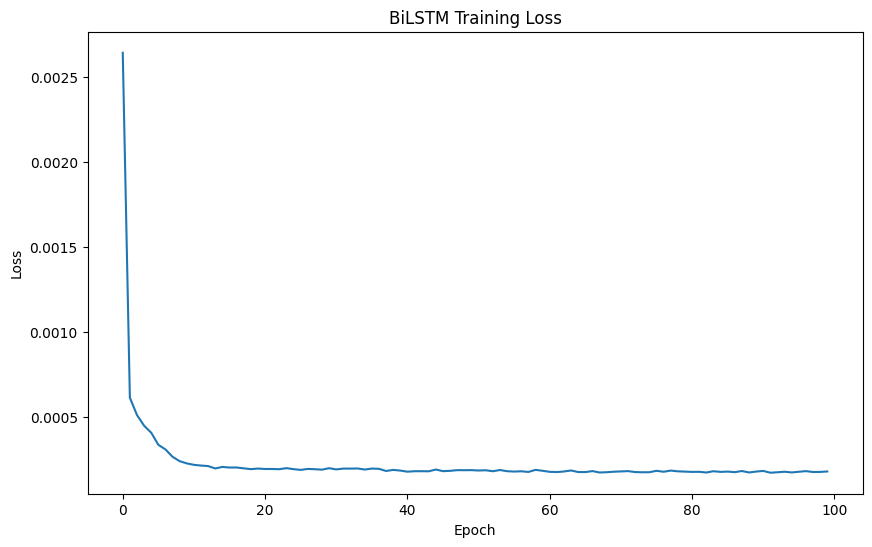

Making hybrid predictions...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluating model performance...
Mean Squared Error: 66695.38
Root Mean Squared Error: 258.25
Mean Absolute Error: 215.37
Mean Absolute Percentage Error: 0.60%
R² Score: 0.9979


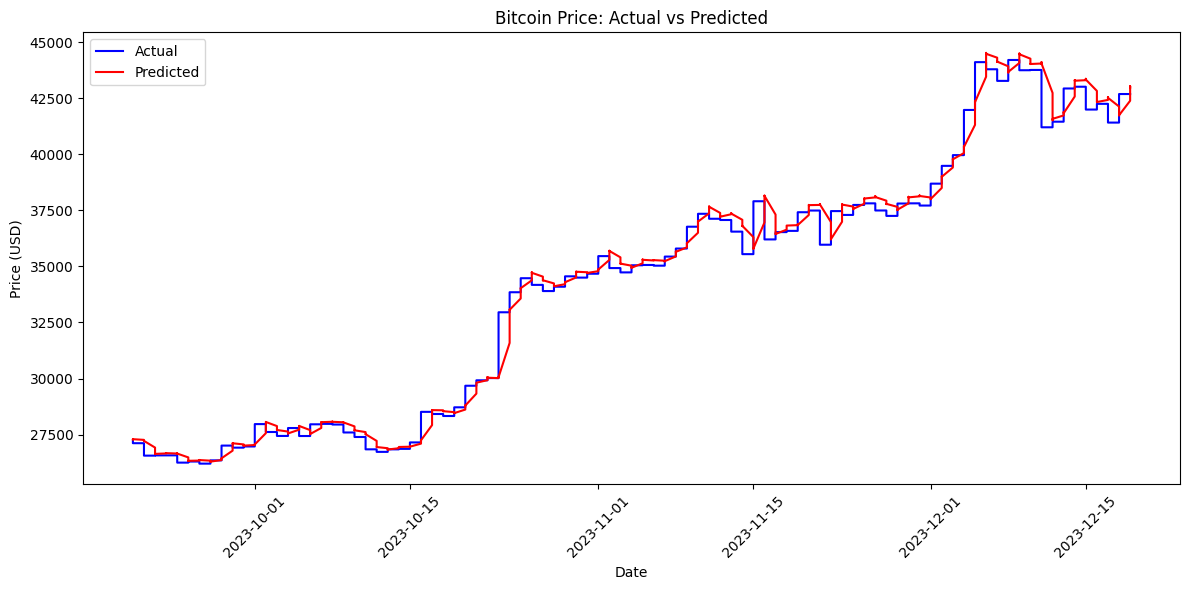

Saving model...
Models saved in models with timestamp 20250424_214527
Model saved with timestamp: 20250424_214527


In [5]:
def main():
    # Load the Bitcoin data
    df = pd.read_csv('merged_news_price.csv')

    # Print sample of the data
    print("Sample of the data:")
    print(df.head())

    # Create the hybrid model
    hybrid_model = HybridModel(sequence_length=14)

    # Preprocess the data
    df_processed = hybrid_model.preprocess_data(df)
    print("Processed data shape:", df_processed.shape)
    df_processed.to_csv("df_processed_merged_news_price.csv", index=False)

    # Split the data into training, validation, and test sets (70%, 15%, 15%)
    train_size = int(len(df_processed) * 0.7)
    val_size = int(len(df_processed) * 0.15)

    df_train = df_processed.iloc[:train_size]
    df_val = df_processed.iloc[train_size:train_size+val_size]
    df_test = df_processed.iloc[train_size+val_size:]

    print(f"Train set size: {len(df_train)}")
    print(f"Validation set size: {len(df_val)}")
    print(f"Test set size: {len(df_test)}")

    # Prepare data for ARIMAX
    y_train_arimax, X_train_arimax = hybrid_model.prepare_arimax_data(df_train)
    y_val_arimax, X_val_arimax = hybrid_model.prepare_arimax_data(df_val)
    y_test_arimax, X_test_arimax = hybrid_model.prepare_arimax_data(df_test)

    # Prepare data for BiLSTM
    X_train_lstm, y_train_lstm = hybrid_model.prepare_bilstm_data(df_train)
    X_val_lstm, y_val_lstm = hybrid_model.prepare_bilstm_data(df_val)
    X_test_lstm, y_test_lstm = hybrid_model.prepare_bilstm_data(df_test)

    print(f"LSTM training data shape: {X_train_lstm.shape}, {y_train_lstm.shape}")

    # Train ARIMAX model
    print("Training ARIMAX model...")
    arimax_model = hybrid_model.train_arimax(y_train_arimax, X_train_arimax)

    # Find best BiLSTM parameters with grid search
    print("Performing grid search for BiLSTM parameters...")
    best_params, best_model_state = hybrid_model.grid_search_bilstm(
        X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm
    )

    # Train BiLSTM model with best parameters
    print("Training BiLSTM model with best parameters...")
    bilstm_model = hybrid_model.train_bilstm(X_train_lstm, y_train_lstm, best_params, epochs=100)

    # Make hybrid predictions on test set
    print("Making hybrid predictions...")
    # predictions = hybrid_model.make_hybrid_predictions(X_test_lstm, X_test_arimax)
    predictions, sequence_gap = hybrid_model.make_hybrid_predictions(X_test_lstm, X_test_arimax)

    # Adjust actual prices for evaluation to match prediction length
    print("Evaluating model performance...")
    if sequence_gap > 0:
        actual_prices = df_test['target'].values[sequence_gap:].reshape(-1, 1)
        dates_for_plot = df_test.index[sequence_gap:]
    else:
        actual_prices = df_test['target'].values.reshape(-1, 1)
        dates_for_plot = df_test.index
    metrics = hybrid_model.evaluate_model(actual_prices, predictions)

    # Plot predictions
    hybrid_model.plot_predictions(actual_prices, predictions, dates=dates_for_plot)


    # Save the model
    print("Saving model...")
    model_timestamp = hybrid_model.save_model()
    print(f"Model saved with timestamp: {model_timestamp}")

if __name__ == "__main__":
    main()